# K-Soccer Football Object Detection Project Explanation

This is the explanation of the image processing and deep learning techniques used in this object detection project.
First, let's import the neccessary tools and libraries

In [1]:
import cv2
import time
import torch
import numpy as np
from ultralytics import YOLO
from collections import Counter
import os
from matplotlib import pyplot as plt
from IPython.display import Image
from sklearn.cluster import KMeans
import numpy as np


In [3]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")
yolo = YOLO("yolov8x")


!yolo task=detect mode=predict model=yolov8n.pt source=media/image.png project=./runs conf=0.5

Image("runs/predict/image.png")

As we can see, the players are detected however the ball is not, we will fix this later on.
For now we can label the players with their corresponding class (team color) using the average color of each player box.

Let's plot each mean color.

results = yolo("media/image.png", classes = [0,32], conf = 0.5, stream=True) # class 0 -> person, class 32 -> ball

frame = cv2.imread("media/image.png")
player_colors = []
for result in results:
    boxes = result.boxes
    for box in boxes:

        # convert box attributes from tensor to arrays
        coords = box.xyxy.cpu().numpy()[0].astype(int)
        class_id = int(box.cls.cpu().numpy()[0])
        confidence = box.conf.cpu().numpy()[0]
        
        x1, y1, x2, y2 = coords
        
        # crop the frame with box coords
        crop_frame = frame[y1:y2, x1:x2]

    
        mean_color = np.mean(crop_frame, axis=(0,1)).astype(int)

        cv2.rectangle(frame, 
                            (x1, y1), 
                            (x2, y2), 
                            (int(mean_color[0]), int(mean_color[1]), int(mean_color[2])), 
                            10)

        label = f"{'Person' if class_id == 0 else 'Ball'}: {confidence:.2f}"
        color_text = f"RGB: {mean_color[0]},{mean_color[1]},{mean_color[2]}"
        cv2.putText(frame, 
                    label, 
                    (x1, y1 - 25), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, 
                    (255, 255, 255), 
                    2)
        cv2.putText(frame, 
                    color_text, 
                    (x1, y1 - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    0.4, 
                    (255, 255, 255), 
                    1)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

As seen, the floor color is interfering so we will center each box to detect only the T-shirts mean color.
 

Additionally we will assign each mean color to the nearest extreme color detected, using color distances techniques.

In [51]:
def color_distance(color1, color2):
    """Calculate Euclidean distance between two colors"""
    return np.sqrt(np.sum((color1 - color2) ** 2))

def assign_team(color, team_colors):
    """Assign a color to the closest team based on color distance"""
    if not team_colors.any():
        return 0
    distances = [color_distance(color, team_color) for team_color in team_colors]
    return np.argmin(distances)

    
def preprocess_frame(frame):
    """
    Enhance frame for better object detection and color recognition
    Args:
        frame: Input BGR frame
    Returns:
        processed_frame: Enhanced frame
    """
    # Convert to HSV color space
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # Apply CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    h, s, v = cv2.split(hsv)  # Unpack directly into variables
    v = clahe.apply(v)  # Apply CLAHE to V channel
    s = clahe.apply(s)  # Also enhance saturation for better color detection
    hsv = cv2.merge([h, s, v])  # Merge back
    
    # Noise reduction with bilateral filter (preserves edges)
    denoised = cv2.bilateralFilter(hsv, d=9, sigmaColor=75, sigmaSpace=75)
    
    # Convert back to BGR
    processed = cv2.cvtColor(denoised, cv2.COLOR_HSV2BGR)
    
    # Sharpen the image
    kernel_sharpen = np.array([[-1,-1,-1],
                              [-1, 9,-1],
                              [-1,-1,-1]])
    processed_frame = cv2.filter2D(processed, -1, kernel_sharpen)
    
    # Additional contrast enhancement in BGR space
    lab = cv2.cvtColor(processed_frame, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    lab = cv2.merge([l,a,b])
    processed_frame = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    return processed_frame

def process_detections(frame, results):
        
        player_colors = []   
        player_boxes = []    
        ball_candidates = [] 

        
        processed_frame = preprocess_frame(frame)

        for result in results:
            boxes = result.boxes
            for box in boxes:
                if len(box.xyxy) >= 1:

                    class_id = int(box.cls.cpu().numpy()[0])

                    if class_id == 0:
                        x1, y1, x2, y2 = box.xyxy.cpu().numpy()[0].astype(int)



                        # centering the box
                        mid_x = (x1 + x2) // 2
                        mid_y = (y1 + y2) // 2
                        half_height = (y2 - y1) // 2
                        half_width = (x2 - x1) // 2
                        centered_x1 = max(x1, mid_x - half_width // 2)
                        centered_x2 = min(x2, mid_x + half_width // 2)
                        centered_y1 = max(y1, mid_y - half_height // 2)
                        centered_y2 = min(y2, mid_y + half_height // 2)

                        crop_frame = processed_frame[centered_y1:centered_y2, centered_x1:centered_x2]
                        mean_color = np.mean(crop_frame, axis=(0,1)).astype(int)
                        
                        
                        player_colors.append(mean_color)

                        player_boxes.append({
                        'coords': (centered_x1, centered_y1, centered_x2, centered_y2),
                        'color': mean_color,
                        })

                        
                        
                        color_text = f"RGB: {mean_color[0]},{mean_color[1]},{mean_color[2]}"

                        cv2.putText(frame, 
                            color_text, 
                            (x1, y1 - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 
                            0.4, 
                            (255, 255, 255), 
                            1)
                                
        # Use K-means to find team colors

        if len(player_colors) >= 2:
            kmeans = KMeans(n_clusters=2, random_state=42)
            kmeans.fit(player_colors)
            team_colors = kmeans.cluster_centers_
        
            # Second pass: draw boxes with team colors
            for player in player_boxes:
                team = assign_team(player['color'], team_colors)
                x1, y1, x2, y2 = player['coords']                
                # Add team label
                label = f"Team {team+1}"
                
                team_color = team_colors[team]
                if team == 0:
                    cv2.rectangle(frame, 
                                (x1, y1), 
                                (x2, y2), 
                                (30,144,255), 
                                2)
                elif team == 1:
                    cv2.rectangle(frame, 
                                (x1, y1), 
                                (x2, y2), 
                                (255,0,0), 
                                2)
                cv2.putText(frame, 
                            label, 
                            (x1, y1 - 45), 
                            cv2.FONT_HERSHEY_SIMPLEX, 
                            0.5, 
                            (255, 255, 255), 
                            2)
        return frame, processed_frame
                


In [49]:
from pathlib import Path
import os

def display_detections(path, frame_skip, frames):
    is_image=False
    if path == 0:
        cap = cv2.VideoCapture(0)
        output_dir = "outputs/webcam"
    else:
        file_ext = Path(path).suffix.lower()

        if file_ext in [".jpg", ".jpeg", ".png"]:
            is_image = True
        else:
            cap = cv2.VideoCapture(path)
            
        output_dir = f"outputs/{Path(path).stem}"


    if not os.path.exists(output_dir):
        os.makedirs(output_dir) 
    else:
        n = 1
        while True:
            new_dir = f"{output_dir}_{n}"
            if not os.path.exists(new_dir):
                os.makedirs(new_dir)
                break
            n += 1
        output_dir= new_dir

    n_frames = 0
    
    if is_image:
        frame = cv2.imread(path)
        if frame is not None:
            frame, processed_frame = process_detections(frame, yolo(frame, classes=[0, 32], conf=0.5))
            cv2.imwrite(f"{output_dir}/image_original.png", frame)
            cv2.imwrite(f"{output_dir}/image_preprocessed.png", processed_frame)
            print(f"Results saved in {output_dir}")
        else:
            print("Error: Could not read the image file.")
    else:
        while cap.isOpened() and n_frames < frames:
            ret, frame = cap.read()
            if not ret:
                break  

            frame, processed_frame = process_detections(frame, yolo(frame, classes=[0, 32], conf=0.5))
            
            cv2.imwrite(f"{output_dir}/frame{n_frames}_original.png", frame)
            cv2.imwrite(f"{output_dir}/frame{n_frames}_preprocessed.png", processed_frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

            n_frames += 1

            for _ in range(frame_skip):
                if n_frames >= frames:
                    break
                cap.read()  
                n_frames += 1  

        cap.release()
        cv2.destroyAllWindows()
        print(f"Results saved in {output_dir}")


In [52]:
display_detections("media/image.png", 0, 1)


0: 640x640 7 persons, 283.3ms
Speed: 15.4ms preprocess, 283.3ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved in outputs/image_4


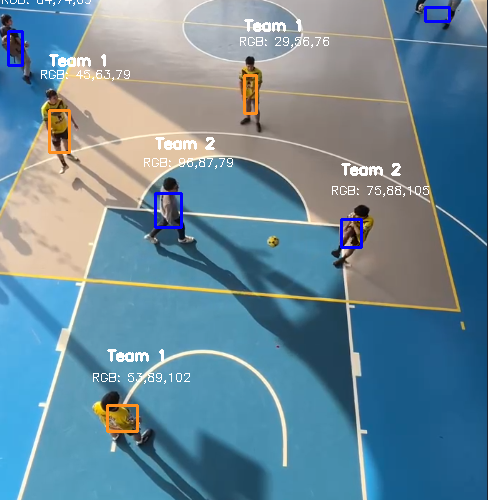

In [53]:
Image("outputs/image_4/image_original.png")

We can improve the accuracy by overshadowing the color of the background